This code calculates the SSIM map for the simulated and experimental images 

In [15]:
# import libraries 

import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from diffusers import AutoencoderKL
from skimage.metrics import structural_similarity as ssim


In [16]:
""" 
This function processes raw experimental patterns and processes them in the desired color format
"""

def preprocess_experimental_initialstage(img_path, img_length=256,img_width=256):

    """
    Preprocess single image in color from rw experimental data.

    Accepts: Input image path 

    Returns: PIL.Image: Color and Cropped image of Experimental data. Cropped exterior is a black masked circle. 

    """

    img = cv2.imread(img_path)

    # Convert the image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find edges in the image using Canny edge detection
    edges = cv2.Canny(img_gray, 100, 200)

    # Find circles in the image using HoughCircles method
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                            param1=50, param2=30, minRadius=20, maxRadius=600)

    # print(circles)

    # Assuming the first detected circle is the plate (adjust accordingly)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x_center, y_center, radius) in circles:
            # Define a new radius for the mask that is 20 pixels smaller than the detected radius
            new_radius = radius -82
            # print(new_radius)

            # Create a mask where all values are set to zero (black)
            mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

            # Draw a filled white circle on the mask where the new, smaller circle is
            cv2.circle(mask, (x_center, y_center), new_radius, (255, 255, 255), -1)

            # Apply the mask to the original image (set pixels outside the new circle to black)
            img_masked = cv2.bitwise_and(img, img, mask=mask)


            # Adjust contrast and brightness
            alpha = 1.5  # Contrast control (1.0-3.0)
            beta = 50    # Brightness control (0-100)
            adjusted_image = cv2.convertScaleAbs(img_masked, alpha=alpha, beta=beta)

            

            # Convert BGR images to RGB for plotting with matplotlib
            img_masked_rgb = cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2RGB)
            # output_img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

        

            # resize both the adjusted image and the mask
            img_resized = cv2.resize(img_masked_rgb, (img_length, img_width))
            mask_resized = cv2.resize(mask,(img_length, img_width),interpolation=cv2.INTER_NEAREST)

            # re-mask the resized image to force a black border outside the circle
            img_masked_resized = cv2.bitwise_and(img_resized,img_resized,mask=mask_resized)
            return img_masked_resized
    else:
        print("No circles were found")
        return None



In [17]:
"""Function to convert tensor to PIL images"""
def tensor_to_pil_v2(tensor):
    tensor = tensor.permute(1,2,0)  # Convert to  (height, width, channels)
    return [Image.fromarray((img.numpy() * 255).astype('uint8')) for img in tensor]


In [18]:
"""
Display simulated patterns and their corresponding experimental patterns. 

"""
files_list  =['105_1.TIF','990_2.TIF','134_1.TIF','102_2.TIF','Fixed_19_1.TIF','20_1.TIF','Fixed_29_1.TIF','72_1.TIF','Fixed_4_2.TIF','Fixed_6_1.TIF']



In [19]:

def tensor_to_pil_v2(tensor):
    # tensor: [channels, height, width]
    tensor = tensor.cpu().numpy()
    tensor = np.transpose(tensor, (1, 2, 0))  # Convert to (height, width, channels)
    image = (tensor * 255).astype('uint8')
    
    # Handle grayscale images
    if image.shape[2] == 1:
        image = image.squeeze(axis=2)
        return Image.fromarray(image, mode='L')
    else:
        return Image.fromarray(image)

def compute_ssim(original_images, reconstructed_images):
    ssim_values = []
    batch_size = original_images.shape[0]
    
    for i in range(batch_size):
        original = original_images[i].cpu().numpy()  # Shape: [channels, height, width]
        reconstructed = reconstructed_images[i].cpu().numpy()
        
        # Convert to [height, width, channels]
        original = np.transpose(original, (1, 2, 0))
        reconstructed = np.transpose(reconstructed, (1, 2, 0))
        
        # Ensure images are at least 7x7 pixels
        min_dim = min(original.shape[0], original.shape[1])
        if min_dim < 7:
            win_size = min_dim if min_dim % 2 == 1 else min_dim - 1
        else:
            win_size = 7  # Default value
        
        # Determine channel_axis
        if original.shape[2] == 1:
            channel_axis = None
            original = original.squeeze(axis=2)
            reconstructed = reconstructed.squeeze(axis=2)
        else:
            channel_axis = 2
        
        # Compute SSIM
        ssim_index = ssim(original, reconstructed, data_range=1, win_size=win_size, channel_axis=channel_axis)
        ssim_values.append(ssim_index)
    
    return ssim_values

def display_images_with_ssim(reference_images, comparison_images, num_samples=3):
    fig, axes = plt.subplots(3,num_samples, figsize=(num_samples * 4,12),layout='constrained')
    # fig.subplots_adjust(hspace=0.3, wspace=0.5)

    for i in range(num_samples):
        ref_image = tensor_to_pil_v2(reference_images[i])
        comp_image = tensor_to_pil_v2(comparison_images[i])

        # print(type(ref_image))
        # print(type(comp_image))
        
        # Compute SSIM score
        ref_array = np.array(ref_image.convert('L')) / 255.0  # Convert to grayscale for SSIM
        comp_array = np.array(comp_image.convert('L')) / 255.0
        ssim_score = ssim(ref_array, comp_array, data_range=1.0)  # Specify data_range=1.0 for normalized images

        # Display images and SSIM score
        axes[0, i].imshow(ref_image, cmap='gray')
        axes[0, i].axis('off')
        # axes[i, 0].set_title('Reference')

        axes[1, i].imshow(comp_image, cmap='gray')
        axes[1, i].axis('off')
        # axes[i, 1].set_title('Comparison')

        axes[2, i].text(0.5, 0.5, f' {ssim_score:.3f}', ha='center', va='center', fontsize=60)
        axes[2, i].axis('off')
        # axes[i, 2].set_title('SSIM Score')
    # plt.tight_layout()
    plt.show()

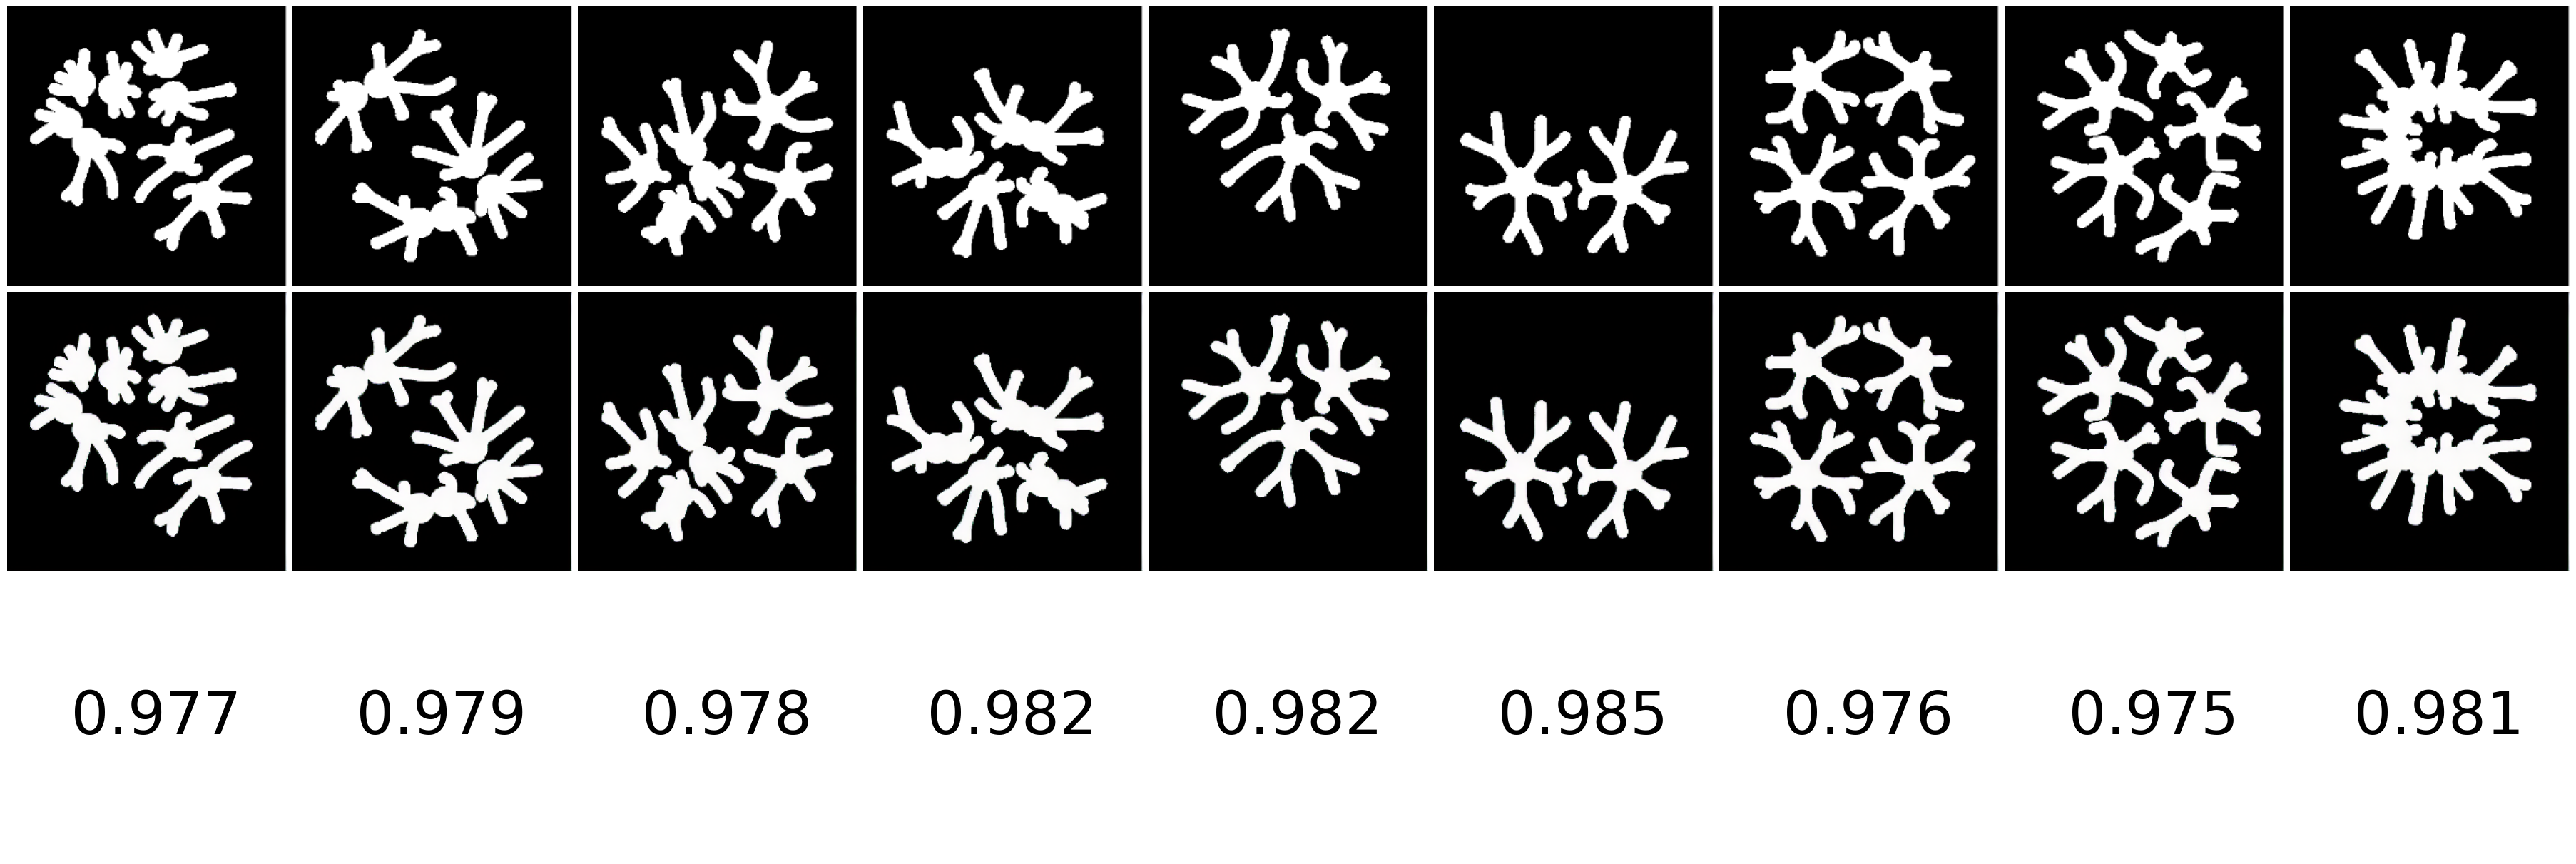

In [20]:
"""Load simulated images, preprocess involves resizing and converting to RGB format """


foldername='/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_031524/Selected_v4_ALL'
sim_img_array=[]

for img in files_list:
    sim_path=os.path.join(foldername,img)
    sim_img=cv2.imread(sim_path, cv2.IMREAD_GRAYSCALE)
    sim_img_array.append(sim_img)

# Set resizing factor
rfactor = 256

# Prepare the simulated data
simulated_data = []

def create_simulated_dataset():
    for img in sim_img_array:

        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize it for consistency
        img_rgb_resized = cv2.resize(img_rgb, (rfactor, rfactor))
        simulated_data.append(img_rgb_resized)

    image_shape = simulated_data[0].shape
    return image_shape


shape_row,shape_col,shape_channel=create_simulated_dataset()


X1=simulated_data  
X1 = np.array(X1)
X1 = np.transpose(X1, (0, 3, 1, 2))  # Convert from (N, H, W, C) to (N, C, H, W)
X1 = X1 / 255.0  # Normalize the images

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
X = torch.Tensor(X1)

'''
Define pre-trained SD VAE for encoding simulated patterns and decoding latents back to image space.

'''

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

def encode_img(input_img):
    # input_img = input_img.repeat(3, 1, 1)
    
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    if len(input_img.shape)<4:
        input_img = input_img.unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(input_img*2 - 1) # Note scaling  # to make outputs from -1 to 1 
    return 0.18215 * latent.latent_dist.sample()

def decode_img(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)    # to make outputs from 0 to 1 
    image = image.detach()
    return image


# Encode the images
encoded_latents = []

# encode latent of 100000 images

for img in range(0, X.shape[0]) :
    latent = encode_img(X[img,:,:,:])
    encoded_latents.append(latent)


# Simulating input image data as a list of random torch tensors
input_images_list=encoded_latents

# Convert the list of tensors to a numpy array
image_np = np.concatenate(input_images_list, axis=0)

yprime=image_np
yprime=torch.Tensor(yprime)

reconstructed_images=decode_img(yprime)

display_images_with_ssim(X[0:9], reconstructed_images[0:9], num_samples=9)


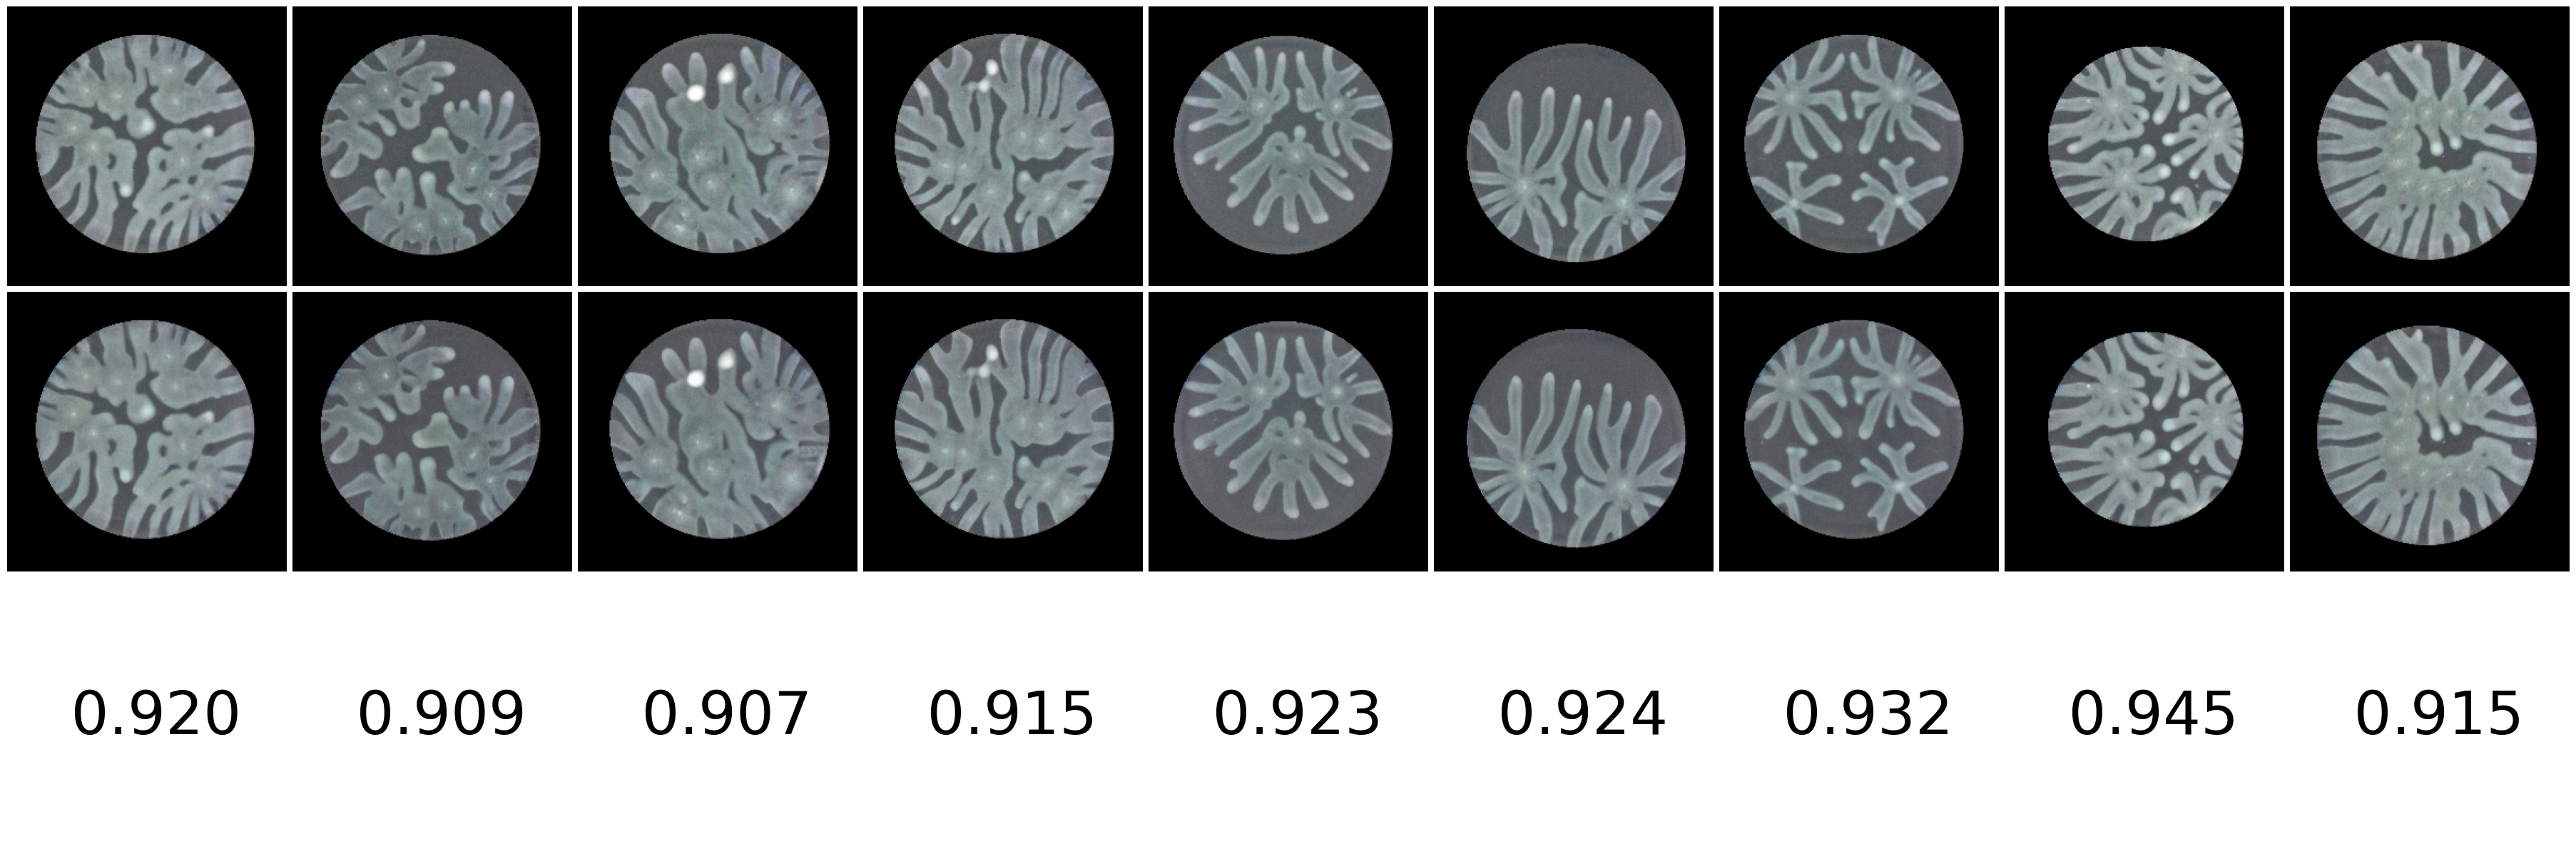

In [21]:
"""Load experimental images, preprocess involves cropping plate and adjusting contrast """

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

rfactor=256  
img_length=rfactor
img_width=rfactor

datadir_exp='/hpc/group/youlab/ks723/storage/Exp_images/Final_folder_uniform_fixedseed' 
path_exp=os.path.join(datadir_exp)

experimental_data=[]

def create_experimental_data():
    img_filenames_i = files_list

    for img in img_filenames_i:

        exp_path= os.path.join(path_exp, img)
        img_array =preprocess_experimental_initialstage(exp_path, img_length=img_length, img_width=img_width)
        experimental_data.append(img_array)
        
            
create_experimental_data()

X=experimental_data  
X=(np.array(X))
X=np.transpose(X, (0,3,1,2))

# normalizing images here to be bw 0 and 1 
X=X/255.0 

# Convert numpy arrays to torch tensors
X = torch.Tensor(X)


'''
Using pre-trained SD VAE for encoding experimental patterns and decoding latents back to image space.

'''

# Encode the images
encoded_latents = []

# encode latent of 100000 images

for img in range(0, X.shape[0]) :
    latent = encode_img(X[img,:,:,:])
    encoded_latents.append(latent)

# Simulating input image data as a list of random torch tensors
input_images_list=encoded_latents

# Convert the list of tensors to a numpy array
image_np = np.concatenate(input_images_list, axis=0)



yprime=image_np
yprime=torch.Tensor(yprime)

reconstructed_images=decode_img(yprime)

display_images_with_ssim(X[0:9], reconstructed_images[0:9], num_samples=9)